In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt").read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [8]:
# Build vocabulary and mappings
chars = sorted(list(set("".join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
s_to_i["."] = 0

i_to_s = {i: s for s, i in s_to_i.items()}
i_to_s


{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

### Building the dataset


In [71]:
CONTEXT_LENGTH = 3  # Block size: number of previous characters to consider when predicting the next character
X, Y = [], []

for word in words[:5]:
    print(word)
    context = [0] * CONTEXT_LENGTH

    for char in word + ".":
        ix = s_to_i[char]
        X.append(context)
        Y.append(ix)

        print("".join([i_to_s[i] for i in context]), "--->", i_to_s[ix])
        context = context[1:] + [ix]

    print("=" * 10)

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [73]:
X.shape, Y.shape, X.dtype, Y.dtype


(torch.Size([32, 3]), torch.Size([32]), torch.int64, torch.int64)

In [72]:
X[:10], Y[:10]


(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9]))

#### Creating the embeddings matrix


In [74]:
embed_size = 2
# 2-dimension embeddings
C = torch.randn(size=(len(chars) + 1, embed_size))

C


tensor([[-0.0420,  0.5207],
        [ 0.3652,  0.0816],
        [-0.1530,  0.3086],
        [ 0.3903, -0.2723],
        [-0.4222,  0.3062],
        [-0.8584, -0.2627],
        [ 0.7122,  0.4641],
        [-0.8772, -0.1745],
        [ 0.4187,  1.9763],
        [-1.3171,  0.0475],
        [-1.0068,  0.4175],
        [ 0.6012,  0.1996],
        [-0.7944,  0.6257],
        [-1.7710, -0.2458],
        [-0.8173, -0.3824],
        [ 0.5338,  0.8790],
        [ 1.0532,  0.1871],
        [-0.1977,  0.8671],
        [ 0.2085,  0.3644],
        [-2.5613, -0.5468],
        [ 0.6147,  0.3374],
        [-0.4286, -0.4828],
        [-1.7391,  1.9912],
        [ 0.2624,  0.5821],
        [ 0.5976,  1.2198],
        [-0.3465, -1.5540],
        [-0.8701,  1.2346]])

In [75]:
# Using one-hot encoding to get the embeddings
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

# Directly indexing the embeddings
C[5]

# Both approaches are equivalent, but the latter is faster since it doesn't require a matrix multiplication.


tensor([-0.8584, -0.2627])

In [76]:
emb = C[X]
emb.shape


torch.Size([32, 3, 2])

### Building the model


In [108]:
num_neurons = 100


In [109]:
W1 = torch.randn(size=(embed_size * CONTEXT_LENGTH, num_neurons))
b1 = torch.randn(size=(num_neurons,))
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

In [110]:
# Flatten the embeddings and multiply by the weight matrix
h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)


In [114]:
h.shape


torch.Size([32, 100])

In [111]:
W2 = torch.randn(size=(num_neurons, len(chars) + 1))
b2 = torch.randn(size=(len(chars) + 1,))
W2.shape, b2.shape


(torch.Size([100, 27]), torch.Size([27]))

In [116]:
logits = (h @ W2) + b2
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

probs.shape


torch.Size([32, 27])

In [120]:
# Predicted probabilities for the correct next character
probs[torch.arange(len(Y)), Y]


tensor([5.4996e-07, 1.1747e-05, 2.6083e-05, 9.0551e-13, 1.5539e-06, 1.6197e-11,
        1.8982e-09, 1.2461e-15, 3.3361e-05, 5.3247e-21, 3.0923e-06, 1.7050e-02,
        6.4599e-04, 7.6131e-07, 3.5826e-09, 1.8902e-11, 1.0886e-11, 9.9986e-01,
        7.8533e-17, 2.5269e-06, 9.8285e-01, 4.3992e-08, 6.0773e-08, 1.4893e-05,
        4.8923e-06, 5.3397e-03, 4.3359e-14, 1.7462e-14, 1.0847e-10, 4.7468e-13,
        8.7592e-03, 8.0191e-10])

In [121]:
# Computing the loss function
loss = probs[torch.arange(len(Y)), Y].log().neg().mean()


### Optimizing the MLP


In [195]:
CONTEXT_LENGTH = 3  # Block size: number of previous characters to consider when predicting the next character
X, Y = [], []

for word in words:
    # print(word)
    context = [0] * CONTEXT_LENGTH

    for char in word + ".":
        ix = s_to_i[char]
        X.append(context)
        Y.append(ix)

        # print("".join([i_to_s[i] for i in context]), "--->", i_to_s[ix])
        context = context[1:] + [ix]

    # print("=" * 10)

X = torch.tensor(X)
Y = torch.tensor(Y)

In [196]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [237]:
num_neurons = 100
embed_size = 2

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(len(chars) + 1, embed_size), generator=g, requires_grad=True)
W1 = torch.randn(
    size=(embed_size * CONTEXT_LENGTH, num_neurons), generator=g, requires_grad=True
)
b1 = torch.randn(size=(num_neurons,), generator=g, requires_grad=True)
W2 = torch.randn(size=(num_neurons, len(chars) + 1), generator=g, requires_grad=True)
b2 = torch.randn(size=(len(chars) + 1,), generator=g, requires_grad=True)

params = [C, W1, b1, W2, b2]

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 3481


#### Mini-batch gradient descent
Instead of running fewer epochs on the whole dataset, we can run more epochs on smaller batches of the dataset. This is called mini-batch gradient descent. It is usually the preferred method for training neural networks, as it is less computationally expensive and more stable than batch gradient descent.

##### Choosing the learning rate

In [226]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
losses = []

epochs = 1000
minibatch_size = 32

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X.shape[0], size=(minibatch_size,))

    # Forward pass
    emb = C[X[batch_ix]]
    h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)
    logits = (h @ W2) + b2

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Y[batch_ix])

    # if epoch % 10 == 0:
    #     print(f"{epoch=}, {loss=:.4f}")

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    lr = lrs[epoch]
    for p in params:
        p.data += -lr * p.grad

    lri.append(lre[epoch])
    losses.append(loss.item())

# Loss after training
print(f"Loss after {epochs=} {loss=:.4f}")

Loss after epochs=1000 loss=7.5137


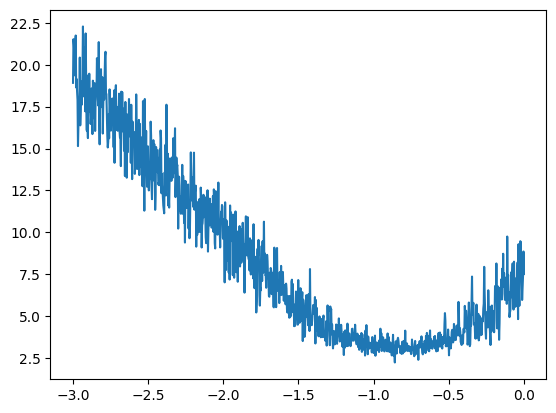

In [227]:
plt.plot(lri, losses)

# The optimal learnring rate seems to be around 1e-1

##### Optimizing with learning rate = `1e-1`

In [245]:
learning_rate = 1e-2
epochs = 10000
minibatch_size = 32

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X.shape[0], size=(minibatch_size,))

    # Forward pass
    emb = C[X[batch_ix]]
    h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)
    logits = (h @ W2) + b2

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Y[batch_ix])

    # if epoch % 10 == 0:
    #     print(f"{epoch=}, {loss=:.4f}")

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data += -learning_rate * p.grad

# Loss after training
print(f"Loss after {epochs=} {loss=:.4f}")

Loss after epochs=10000 loss=2.6333


In [246]:
# Computing the loss on the entire data
emb = C[X]
h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)
logits = (h @ W2) + b2

loss = F.cross_entropy(logits, Y)
print(f"Loss on the entire data: {loss=}")

Loss on the entire data: loss=tensor(2.3604, grad_fn=<NllLossBackward0>)


### Train-val-test split
To correctly evaluate model performance, it is typically split into three parts:
1. Training set: the data used to train the model (weights and biases)
2. Validation set: the data used to train the hyperparameters of the model (learning rate, number of neurons, etc.)
3. Test set: the data used to evaluate the model performance



In [251]:
def build_dataset(words, label):
    CONTEXT_LENGTH = 3  # Block size: number of previous characters to consider when predicting the next character
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * CONTEXT_LENGTH

        for char in word + ".":
            ix = s_to_i[char]
            X.append(context)
            Y.append(ix)

            # print("".join([i_to_s[i] for i in context]), "--->", i_to_s[ix])
            context = context[1:] + [ix]

        # print("=" * 10)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(label, X.shape, Y.shape)
    return X, Y

In [252]:
import random

random.seed(42)

# Shuffle the words in the dataset
random.shuffle(words)

# Split the dataset into train, validation and test sets
train_index = int(0.8 * len(words))
val_index = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:train_index], "train")
X_val, Y_val = build_dataset(words[train_index:val_index], "validation")
X_test, Y_test = build_dataset(words[val_index:], "test")

train torch.Size([182580, 3]) torch.Size([182580])
validation torch.Size([22767, 3]) torch.Size([22767])
test torch.Size([22799, 3]) torch.Size([22799])


In [256]:
X_train.shape, Y_train.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [290]:
num_neurons = 300
embed_size = 2

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(len(chars) + 1, embed_size), generator=g, requires_grad=True)
W1 = torch.randn(
    size=(embed_size * CONTEXT_LENGTH, num_neurons), generator=g, requires_grad=True
)
b1 = torch.randn(size=(num_neurons,), generator=g, requires_grad=True)
W2 = torch.randn(size=(num_neurons, len(chars) + 1), generator=g, requires_grad=True)
b2 = torch.randn(size=(len(chars) + 1,), generator=g, requires_grad=True)

params = [C, W1, b1, W2, b2]

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 10281


In [322]:
learning_rate = 1e-2
epochs = 30000
minibatch_size = 32

losses = []
steps = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(minibatch_size,))

    # Forward pass
    emb = C[X_train[batch_ix]]
    h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)
    logits = (h @ W2) + b2

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Y_train[batch_ix])

    # if epoch % 10 == 0:
    #     print(f"{epoch=}, {loss=:.4f}")

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    # Update the parameters
    for p in params:
        p.data += -learning_rate * p.grad

    steps.append(epoch)
    losses.append(loss.item())

# Loss after training
print(f"Loss after {epochs=} {loss=:.4f}")

Loss after epochs=30000 loss=2.2062


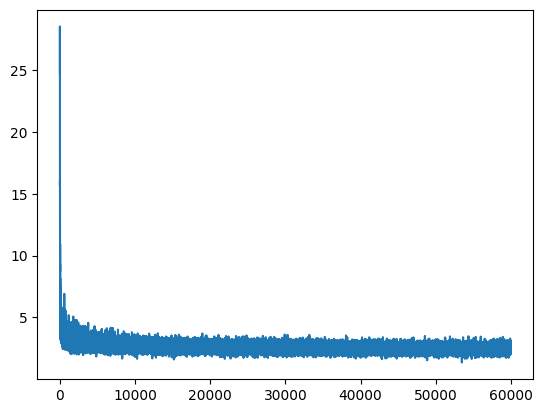

In [292]:
plt.plot(steps, losses)

In [323]:
# Computing the loss on the training data
emb = C[X_train]
h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)
logits = (h @ W2) + b2

loss = F.cross_entropy(logits, Y_train)
print(f"Loss on the training data: {loss=}")

Loss on the training data: loss=tensor(2.2585, grad_fn=<NllLossBackward0>)


In [324]:
# Computing the loss on the validation data
emb = C[X_val]
h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)
logits = (h @ W2) + b2

loss = F.cross_entropy(logits, Y_val)
print(f"Loss on the validation data: {loss=}")

Loss on the validation data: loss=tensor(2.2676, grad_fn=<NllLossBackward0>)


#### Visualizing the embeddings vector

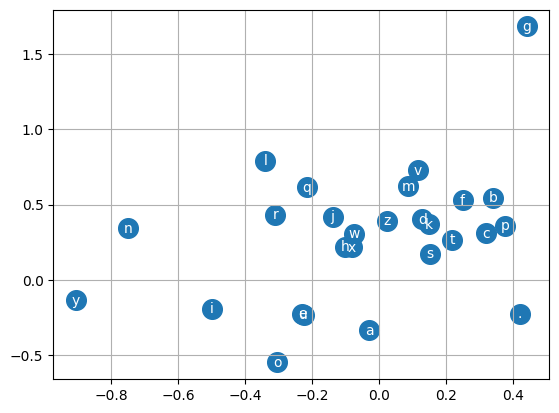

In [326]:
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(len(chars) + 1):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        i_to_s[i],
        ha="center",
        va="center",
        color="white",
    )

plt.grid("minor")

#### Scaling up the embeddings vector

In [346]:
num_neurons = 200
embed_size = 10

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(len(chars) + 1, embed_size), generator=g, requires_grad=True)
W1 = torch.randn(
    size=(embed_size * CONTEXT_LENGTH, num_neurons), generator=g, requires_grad=True
)
b1 = torch.randn(size=(num_neurons,), generator=g, requires_grad=True)
W2 = torch.randn(size=(num_neurons, len(chars) + 1), generator=g, requires_grad=True)
b2 = torch.randn(size=(len(chars) + 1,), generator=g, requires_grad=True)

params = [C, W1, b1, W2, b2]

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 11897


In [347]:
losses = []
steps = []

In [348]:
epochs = 200000
minibatch_size = 32

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(minibatch_size,))

    # Forward pass
    emb = C[X_train[batch_ix]]
    h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)
    logits = (h @ W2) + b2

    # Computing the loss function using cross-entropy
    loss = F.cross_entropy(logits, Y_train[batch_ix])

    # if epoch % 10 == 0:
    #     print(f"{epoch=}, {loss=:.4f}")

    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    learning_rate = 1e-1 if epoch < 100000 else 1e-2

    # Update the parameters
    for p in params:
        p.data += -learning_rate * p.grad

    steps.append(epoch)
    losses.append(loss.log10().item())

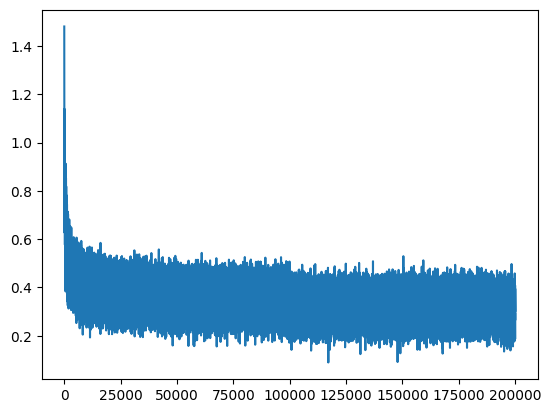

In [349]:
plt.plot(steps, losses)

In [350]:
# Computing the loss on the training data
emb = C[X_train]
h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)
logits = (h @ W2) + b2

loss = F.cross_entropy(logits, Y_train)
print(f"Loss on the training data: {loss=}")

Loss on the training data: loss=tensor(2.1179, grad_fn=<NllLossBackward0>)


In [351]:
# Computing the loss on the validation data
emb = C[X_val]
h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)
logits = (h @ W2) + b2

loss = F.cross_entropy(logits, Y_val)
print(f"Loss on the validation data: {loss=}")

Loss on the validation data: loss=tensor(2.1592, grad_fn=<NllLossBackward0>)


In [352]:
# Computing the loss on the test data
emb = C[X_test]
h = torch.tanh((emb.view(-1, embed_size * CONTEXT_LENGTH) @ W1) + b1)
logits = (h @ W2) + b2

loss = F.cross_entropy(logits, Y_test)
print(f"Loss on the test data: {loss=}")

Loss on the test data: loss=tensor(2.1649, grad_fn=<NllLossBackward0>)


### Predicting from the model

In [376]:
g = torch.Generator().manual_seed(2147483647)
starting_string = ".ad"

for _ in range(20):
    out = []
    context = [s_to_i[s] for s in starting_string]
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh((emb.view(1, -1) @ W1) + b1)
        logits = (h @ W2) + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(
            probs, num_samples=1, replacement=True, generator=g
        ).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print((starting_string + "".join([i_to_s[i] for i in out])).replace(".", ""))

adjunide
adianakar
ada
adelay
adelin
adesi
adritolian
adarie
adamarnaaciania
adalaika
addaine
adie
adalsianiely
adarre
adinviumahan
adetum
adrick
adshiah
adjael
adhora
